### Validation of the final water level maps using timeseries of altimetry data

**Aim**
- There are only 6 water logger timeseries that correspond with our final water level maps. Here, altimetry data is used to further validate the water level maps. 

**Inputs**
- water level maps, output from: create_final_water_level_maps.ipynb
- altimetry dataframes - output from Altimetry_data_calculations-new.ipynb

**Outputs**
- plots and correlation statistics between the Altimetry time series and the water level maps timeseries
- Figure 15 in the paper

**Methods**
- same as for the water logger assessment in Determine_transfer_function_WTD_transects-v2.ipynb

In [ ]:
import sys
import pandas as pd
import xarray as xr
import numpy as np
xr.set_options(cmap_sequential='jet')
import matplotlib.pyplot as plt
import warnings
import netCDF4
import datetime
import plotly
import plotly.express as px
import plotly.graph_objects as go
from affine import Affine
import cartopy.crs as ccrs
import nco
import xesmf as xe
from calendar import monthrange
import pickle as pkl
from datetime import date, datetime, timedelta
import math
import seaborn as sns
from scipy import stats
from IPython.display import display

import scipy.stats

%xmode Minimal

In [1]:
# define input data directory here:
# ALOS_OUT =

### Functions

In [18]:

def extract_WL_at_altimeter_loc(df1):
    
    # identifying unique altimetry data in the list
    names_list = list(df1['name'].unique())
    print (names_list)
    
    df_all = []
    
    for i in range(len(names_list)):
        df = df1.copy()
        alt_name = names_list[i]
        print (alt_name)
        
        # finding the coordinates corresponding with the altimeter name
        df =df[df['name'] == alt_name].copy().reset_index()
        lat1 = df.lat[0]
        lon1 = df.lon[0]

        print ('Coordinates:\n')
        print (lat1, lon1)

        # extracting the data at this point
        WL_list = WL_daily.sel(lon=lon1, lat=lat1, method='nearest')
        WL_df = WL_list['water_level'].to_dataframe().reset_index()
        WL_df.rename(columns = {'time':'Date'}, inplace=True)

        df_final = pd.merge(WL_df[['Date','water_level']], df, how='inner', on=['Date'])

        print (df_final.water_level[10])
        
        # if there is any available interpolated data at this location, then add it to the array
        if df_final.water_level[10] >-1000:
            df_all.append(df_final)
        
    if len(df_all) > 0:
        df_new = pd.concat(df_all).reset_index(drop=True)
        return (df_new)
    else:
        print ('There is no interpolated water level data at these locations.')
   

In [3]:
import matplotlib.dates as mdates

    
def annotate_plot(x, y, col, altimeters, **kwargs):
    ax = plt.gca()
    text = kwargs.pop('text')
    texts = {'altimeters[0]': 'text for col1', altimeters[1]: 'text for col2', altimeters[2]: 'text for col3', altimeters[3]: 'text for col4'}
    #Convert x to datetime
    x = pd.to_datetime(x)
    x = x.values
    y = y.values
    
    #Set x-axis format
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    #Extract the first element of the Series
    col = col.iloc[0]
    #Annotate text
    ax.annotate(texts[col], xy=(1,1), xytext=(0.5, 0.5),
                textcoords="offset points",
                xycoords="axes fraction",
                ha="right", va="top",
                bbox=dict(boxstyle="round,pad=0.3", fc="yellow", alpha=0.5),
                arrowprops=None)
    
    
    
    
def plot_altimeter_data(df,coords):
    # plots the altimeter and the modelled water levels
    
    print (df.name.unique())
    altimeters = df.name.unique()
    
    df = df.rename(columns = {'name':'altimeter'})

    df_melt = df.melt(id_vars=['Date','altimeter'], value_vars = ['water_level','Elevation'])
    df_melt.columns = ['Date','altimeter','type','depth']
    
    for i in range(len(altimeters)):
        df1 = df[df['altimeter'] == altimeters[i]]
        
        # checking the correlation
        print (altimeters[i] + ' correlation: ') 
        Pearsonr = scipy.stats.pearsonr(df1['Elevation'],df1['water_level'])[0]
        KendallsT = scipy.stats.kendalltau(df1['Elevation'],df1['water_level'])[0]
        SpearmansR = scipy.stats.spearmanr(df1['Elevation'],df1['water_level'])[0]
        print ("Pearsonr: "  + str(round(Pearsonr,2)))
        print ("Kendall's \u03C4: " + str(round(KendallsT,2)))
        print ("Spearman's \u03C1: " + str(round(SpearmansR,2)))
        
        
        
        # adding this to the coordinates array
        #coords.loc[coords['Logger'] == loggers[i],['model corr']] = corr
        coords.loc[coords['Altimeter'] == altimeters[i],["PearsonR"]] = round(Pearsonr,2)
        coords.loc[coords['Altimeter'] == altimeters[i],["Kendall's \u03C4"]] = round(KendallsT,2)
        coords.loc[coords['Altimeter'] == altimeters[i],["Spearman's \u03C1"]] = round(SpearmansR,2)
      
    
    # plotting the graphs
    grid = sns.FacetGrid(data=df_melt,col='altimeter',hue='type',col_wrap=2, size=3.8, legend_out=True)
    grid.map(plt.plot,'Date','depth')
    grid.fig.tight_layout(w_pad=2)
    grid.set_axis_labels(y_var = 'Normalised water level', x_var = '')
    
    # setting the individual sub-plot titles to the loggers array names   
    grid.set_titles(template='{col_name}')
            
    # Add a horizontal line at y=0
    labels = ['Altimeter','Model']
    # Get the handles and labels for the legend
    handles, _ = plt.gca().get_legend_handles_labels()

    # Create the legend
    plt.legend(handles, labels, title='')
    
    # rotating the datetime x axis labels
    for ax in grid.axes.flat:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    #grid.map(annotate_plot, 'Date', 'depth', text = 'test')
    #grid.map(annotate_plot, 'Date', 'depth', 'altimeter', altimeters, text='My annotation text')
    
   
    plt.show()
    
    return (coords)
 


In [4]:
# final water level timeseries
#WL_daily = xr.open_dataset(ALOS_OUT + 'WL_daily_final.nc')

# rainfed only version
WL_daily = xr.open_dataset(ALOS_OUT + 'HH_modelled_water_level_ts.nc')

# full version
WL_daily = xr.open_dataset(ALOS_OUT + 'WL_daily_final.nc')
# processed altimetry data
alt_ps = pd.read_feather(ALOS_OUT + 'altimetry_ps.feather')
alt_hws = pd.read_feather(ALOS_OUT + 'altimetry_hws.feather')

# all altimetry data
alt_all = pd.read_feather(ALOS_OUT + 'altimetry_df.feather')


## Reformatting data columns
# renaming date column
alt_ps.rename(columns={'index':'Date'}, inplace=True)
alt_hws.rename(columns={'index':'Date'}, inplace=True)
alt_ps['type'] = alt_ps['type'].astype('string')
alt_hws['type'] = alt_hws['type'].astype('string')

# changing object columns to numeric
alt_all[['Value','Elevation']] = alt_all[['Value','Elevation']].apply(pd.to_numeric)

# changing date column to datetime
alt_all['Date'] = pd.to_datetime(alt_all['Date'])
alt_all['type'] = alt_all['type'].astype('string')
alt_all = alt_all.drop(['type'], axis=1)

# land type map
lt_map = xr.open_dataset(ALOS_OUT + 'landtype_100m.nc')

# pixel wise correlation slope data
pw_slopes = xr.open_dataset(ALOS_OUT + 'slopes_da_HH_new.nc')
test = pw_slopes.to_array().to_dataset(name='slope')
pw_slopes = test['slope'][0][0].to_dataset(name='slope')
pw_slopes = pw_slopes.where(lt_map['type'].isin([4,5]))
pw_slopes = pw_slopes.drop('variable')

# 2. correlations
pw_corrs = xr.open_dataset(ALOS_OUT + 'corrs_da_HH_new.nc')
test = pw_corrs.to_array().to_dataset(name='correlation')
pw_corrs = test['correlation'][0][0].to_dataset(name='correlation')
pw_corrs = pw_corrs.where(lt_map['type'].isin([4,5]))
pw_corrs = pw_corrs.drop('variable')

# 3. p-values
pw_pvals = xr.open_dataset(ALOS_OUT + 'pvals_da_HH_new.nc')
test = pw_pvals.to_array().to_dataset(name='pvalue')
pw_pvals = test['pvalue'][0][0].to_dataset(name='pvalue')
pw_pvals = pw_pvals.where(lt_map['type'].isin([4,5]))
pw_pvals = pw_pvals.drop('variable')

# 4. standard errors
pw_stderrs = xr.open_dataset(ALOS_OUT + 'stderrs_da_HH_new.nc')
test = pw_stderrs.to_array().to_dataset(name='stderr')
pw_stderrs = test['stderr'][0][0].to_dataset(name='stderr')
pw_stderrs = pw_stderrs.where(lt_map['type'].isin([4,5]))
pw_stderrs = pw_stderrs.drop('variable')

In [ ]:
pw_corrs = xr.open_dataset(ALOS_OUT + 'corrs_da_HH_new.nc')
pw_corrs

In [ ]:
# joining alt_all and alt_ps on lat lon fields
alt_ps = pd.merge(alt_ps, alt_all, how='inner', on=['Date','lat','lon'])

# joining alt_all and alt_hws on lat lon fields
alt_hws = pd.merge(alt_hws, alt_all, how='inner', on=['Date','lat','lon'])

alt_ps

In [15]:
# converting columns to the same units (cm)
df =alt_hws.copy()
df['net water input'] = df['net water input']/10 # mm to cm 
df['delta h'] = df['delta h']*100  # m to cm
df['Value'] = df['Value']*100  # m to cm
df['error'] = df['error']* 100 # m to cm
df.rename(columns={'error': 'compound error','Value':'error'}, inplace=True)
alt_hws = df.copy()

df =alt_ps.copy()

# keeping everything in metres
df['net water input'] = df['net water input']/10 # mm to cm
df['delta h'] = df['delta h'] # *100  # m to cm
df['Value'] = df['Value'] #*100  # m to cm
df['error'] = df['error'] #* 100 # m to cm

# 'Value' is the original error, and 'error' is the compounded error.
# Chaning these column names to make more sense

df.rename(columns={'error': 'compound error','Value':'error'}, inplace=True)

alt_ps = df.copy()

In [19]:
# Altimeter coordinates
# creating a dataframe with the altimeter coordinates
data = [['LOK5_1.0',-0.30320, 18.20069],['LOK5_3.0', -0.31495, 18.18710],['LOK5_4.0', -0.32095, 18.18046],['IKE1_5.0',  0.28348, 18.82755]]
data = [['KM1355',-0.24, 19.23], ['KM1374',0.36, 19.01], ['KM1263',0.27, 18.47], ['KM1360',-0.39, 19.26]]
coords = pd.DataFrame(data, columns = ['Altimeter','lat','lon'])
#print (l_coords)


# extracting pw correlation information at each coord
coords['pixel-wise corr'] = np.nan
coords['p-value'] = np.nan
coords['slope (cm/dB)'] = np.nan
coords['std error (cm)'] = np.nan
coords['PearsonR'] = np.nan
coords["Kendall's \u03C4"] = np.nan
coords["Spearman's \u03C1"] = np.nan

for i, row in coords.iterrows():
    coords.at[i, 'pixel-wise corr'] = np.round(pw_corrs.sel(lon=row['lon'],lat=row['lat'],method='nearest')['correlation'],2)
    #coords.at[i, 'pw_corr2'] = np.round(pw_corrs2.sel(lon=row['lon'],lat=row['lat'],method='nearest')['correlation'],2)

    coords.at[i, 'p-value'] = np.round(pw_pvals.sel(lon=row['lon'],lat=row['lat'],method='nearest')['pvalue'],2)
    coords.at[i, 'slope (cm/dB)'] = np.round(pw_slopes.sel(lon=row['lon'],lat=row['lat'],method='nearest')['slope']/10.,2)
    coords.at[i, 'std error (cm)'] = np.round(pw_stderrs.sel(lon=row['lon'],lat=row['lat'],method='nearest')['stderr']/10.0,2)

coords

,Altimeter,lat,lon,pixel-wise corr,p-value,slope (cm/dB),std error (cm),PearsonR,Kendall's τ,Spearman's ρ
0,KM1355,-0.24,19.23,0.21,0.24,1.38,1.87,NaN,NaN,NaN
1,KM1374,0.36,19.01,0.51,0.03,1.89,0.92,NaN,NaN,NaN
2,KM1263,0.27,18.47,0.02,0.47,0.10,1.34,NaN,NaN,NaN
3,KM1360,-0.39,19.26,0.26,0.19,0.95,1.03,NaN,NaN,NaN


In [ ]:
df_ps = extract_WL_at_altimeter_loc(alt_ps)

['KM1355' 'KM1374' 'KM1263' 'KM1360']
KM1355 correlation: 
Pearsonr: 0.8
Kendall's τ: 0.51
Spearman's ρ: 0.67
KM1374 correlation: 
Pearsonr: 0.76
Kendall's τ: 0.54
Spearman's ρ: 0.74
KM1263 correlation: 
Pearsonr: 0.89
Kendall's τ: 0.72
Spearman's ρ: 0.87
KM1360 correlation: 
Pearsonr: 0.92
Kendall's τ: 0.84
Spearman's ρ: 0.94


/home/s0677837/Datastore/miniconda3/envs/congo3/lib/python3.8/site-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
<ipython-input-33-7ef1b81d1003>:79: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


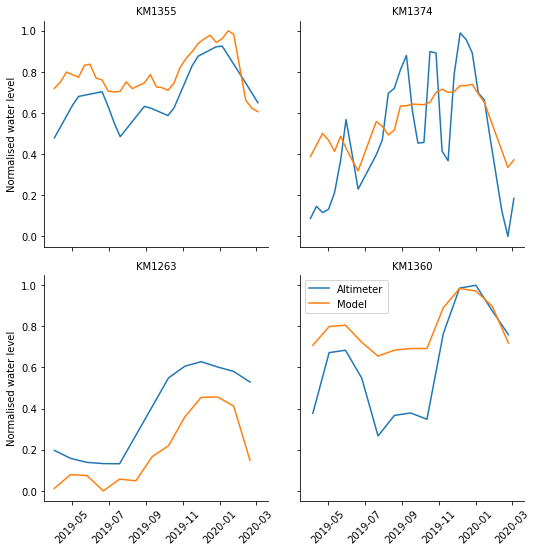

,Altimeter,lat,lon,pixel-wise corr,p-value,slope (cm/dB),std error (cm),PearsonR,Kendall's τ,Spearman's ρ
0,KM1355,-0.24,19.23,0.21,0.24,1.38,1.87,0.80,0.51,0.67
1,KM1374,0.36,19.01,0.51,0.03,1.89,0.92,0.76,0.54,0.74
2,KM1263,0.27,18.47,0.02,0.47,0.10,1.34,0.89,0.72,0.87
3,KM1360,-0.39,19.26,0.26,0.19,0.95,1.03,0.92,0.84,0.94


In [34]:
# Plotting normalised data
df_ps_n = df_ps[['Elevation','water_level', 'net water input']].copy()
df_ps_n = (df_ps_n-df_ps_n.min())/(df_ps_n.max()-df_ps_n.min())
df_ps_n['Date'] = df_ps['Date']
df_ps_n['name'] = df_ps['name']
coords_new = plot_altimeter_data(df_ps_n,coords)
coords_new

In [36]:
print(coords_new.to_latex(index=False))

\begin{tabular}{lrrrrrrrrr}
\toprule
Altimeter &   lat &    lon &  pixel-wise corr &  p-value &  slope (cm/dB) &  std error (cm) &  PearsonR &  Kendall's τ &  Spearman's ρ \\
\midrule
   KM1355 & -0.24 &  19.23 &             0.21 &     0.24 &           1.38 &            1.87 &      0.80 &         0.51 &          0.67 \\
   KM1374 &  0.36 &  19.01 &             0.51 &     0.03 &           1.89 &            0.92 &      0.76 &         0.54 &          0.74 \\
   KM1263 &  0.27 &  18.47 &             0.02 &     0.47 &           0.10 &            1.34 &      0.89 &         0.72 &          0.87 \\
   KM1360 & -0.39 &  19.26 &             0.26 &     0.19 &           0.95 &            1.03 &      0.92 &         0.84 &          0.94 \\
\bottomrule
\end{tabular}



<AxesSubplot:xlabel='Date', ylabel='water_level'>

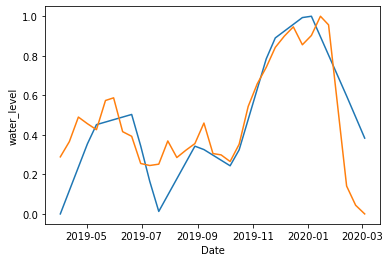

In [ ]:
sns.lineplot(data = df_final_n, x= 'Date', y='water_level')   # modelled
sns.lineplot(data = df_final_n, x= 'Date', y='Elevation')     # altimetery height